In [898]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import requests
#pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 120)
import time
import haversine as hs
import geopandas as gpd
import pyproj
import os
import math

## 1. Data Preparation

### A. Open the Proceesed Trips (DO) Data

In [3]:
# the trip data was already processed for travel time

df = pd.read_csv('Agustus-8/DO 8 Agustus_Processed.csv', dtype={'No Do': 'str'})
# df.drop('Unnamed: 0', axis=1, inplace=True)

In [407]:
df.head(2)

,New_DO_ID,Bus Code,Kode Rute,Nama Rute,Kode Trip_right,Nama Trip,Looping,Alt Nama Trip,Stop ID,Nama Perhentian,Latitude,Longitude,geometry,Urutan,Keterangan,Gpsdatetime,Gpsheading,long_norm,lat_norm
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00122P,LEBAK BULUS,-6.289380,106.774076,POLYGON ((11886055.770242292 -701540.871127376...,1,PERGI,2023-08-08 10:52:29,87.0,106.774230,-6.289628
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00179P,PONDOK PINANG,-6.282128,106.772028,POLYGON ((11885827.787925148 -700728.699573978...,2,PERGI,2023-08-08 08:03:46,6.0,106.771992,-6.282260


In [5]:
df['TimeStart'] = df['TimeStart'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['TimeEnd'] = df['TimeEnd'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [19]:
# df.rename({'Kode Trip': 'Trip ID'}, inplace=True)
# df['Trip ID'] = df['Kode Trip']

In [6]:
df['No Do'].isna().sum()

0

In [7]:
stopseq = pd.read_excel('Agustus-8/Stop Seq 8 Agustus_Updated.xlsx')

In [25]:
stopseq.head(1)

,ID,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Stop ID,Nama Perhentian,Koordinat,Latitude,Longitude,Urutan,Kode PP,Keterangan,Tipe Perhentian,Kategori Rute,Utama / Non,STATUS OPERASI RUTE,STATUS OPERASI HALTE,STATUS OPERASI TRIP GTFS,STATUS OPERASI TRIP TRANSIT,Unnamed: 20,split,Looping
0,1,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00026C,KOTA,-6.13782,106.81387,-6.13782,106.81387,1,1,PERGI,Halte,BRT,Non-Reguler,Operasi,Tidak Operasi,Tidak Beroperasi,Tidak Beroperasi,2,One Trip


In [8]:
namatrip = stopseq[stopseq.duplicated(subset=['Kode Trip'], keep='last')==False]
namatrip = namatrip[['Nama Trip', 'Kode Trip']]

In [9]:
namatrip.head(2)

,Nama Trip,Kode Trip
5,KOTA-HARMONI,1-P01
20,BLOK M-HARMONI,1-P02


In [10]:
df.head(2)

,No Do,No Bus,Kode Rute Real,Tanggal Do,TimeStart,TimeEnd,Rute Real,TTMinutes,Kode Rute,Nama Trip,Kode Trip
0,202308080603431331,BHL220508,7D,2023-08-08,2023-08-08 06:05:00,2023-08-08 07:58:00,TMII-TEGAL PARANG-TMII VIA CAWANG SUTOYO,113.0,7D,TMII-TEGAL PARANG-TMII VIA CAWANG SUTOYO,7D-L06
1,202308080758181741,BHL220508,7D,2023-08-08,2023-08-08 08:07:00,2023-08-08 10:30:00,TMII-TEGAL PARANG-TMII VIA CAWANG SUTOYO,143.0,7D,TMII-TEGAL PARANG-TMII VIA CAWANG SUTOYO,7D-L06


#### Saving the trips into a pickle (for efficiency purpose)

In [50]:
df.to_pickle("./TrialOutputs/20230808_trial_trips_19Jan.pkl")

#### Codes of Bus Used in the Trips

In [11]:
#df['Kode Rute Real']
dfbus = df.groupby(['Kode Rute Real', 'No Bus']).count()['No Do'].reset_index().drop(['No Do'], axis=1)
dfbus.rename(columns={'No Bus':'bus_code'}, inplace=True)
dfbus.head(2)

,Kode Rute Real,bus_code
0,1,BMP175
1,1,MB1610


In [610]:
len(dfbus['bus_code'].unique())

1478

In [52]:
dfbus.to_pickle("./TrialOutputs/20230312_trial_buscodes_8Aug.pkl")

#### All the No Do in Trips Dataframe

In [12]:
duplicates_no_do = df[df.duplicated(subset='No Do', keep=False)].sort_values(by='No Do', ascending=True)

duplicates_no_do

# There won't be duplicates DO if you saved the DO data as csv instead of excel

,No Do,No Bus,Kode Rute Real,Tanggal Do,TimeStart,TimeEnd,Rute Real,TTMinutes,Kode Rute,Nama Trip,Kode Trip


### B. Preprocessing GPS Data

In [55]:
# Data from 08 August 2023. Taking only the trips that start and end between 05:00 to 11:00 

In [17]:
dfgps1 = pd.read_csv('4 & 8 Agustus/20230814_Data GPS 8 Agustus 2023 (00-06).csv', delimiter=',', usecols=[0,1,2,3,4,5,6,7,8,9])
dfgps2 = pd.read_csv('4 & 8 Agustus/20230814_Data GPS 8 Agustus 2023 (06-09).csv', delimiter=',', usecols=[0,1,2,3,4,5,6,7,8,9])
dfgps3 = pd.read_csv('4 & 8 Agustus/20230814_Data GPS 8 Agustus 2023 (09-12).csv', delimiter=',', usecols=[0,1,2,3,4,5,6,7,8,9])

In [14]:
dfgps3.head(2)

,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,location,poi,odometer
0,TSW 092,1M,2023-08-08 09:00:00,106.752125,-6.196604,181.0,18.0,NaN,NaN,316517.56
1,TSW 094,6N,2023-08-08 09:00:00,106.793956,-6.245819,270.0,9.1,NaN,NaN,296879.78


Convert into timestamp and remove the wee hours

In [18]:
dfgps1['gpsdatetime'] = dfgps1['gpsdatetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
dfgps2['gpsdatetime'] = dfgps2['gpsdatetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
dfgps3['gpsdatetime'] = dfgps3['gpsdatetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [93]:
# dfgps3['gpsdatetime'].min()

#### Removing the AMARI operational time GPS

In [19]:
dfgps1 = dfgps1[dfgps1['gpsdatetime']> datetime.strptime('2023-08-08 04:40:00', '%Y-%m-%d %H:%M:%S')]
# dfgps2 = dfgps2[dfgps2['Gpsdatetime']< datetime.strptime('2023-01-19 22:30:00', '%Y-%m-%d %H:%M:%S')]

In [20]:
print(dfgps1['gpsdatetime'].min(), dfgps2['gpsdatetime'].min(), dfgps3['gpsdatetime'].min())
print(dfgps1['gpsdatetime'].max(), dfgps2['gpsdatetime'].max(), dfgps3['gpsdatetime'].max())

2023-08-08 04:40:01 2023-08-08 06:00:00 2023-08-08 09:00:00
2023-08-08 05:59:59 2023-08-08 08:59:59 2023-08-08 11:59:59


In [21]:
dfgps = pd.concat([dfgps1, dfgps2, dfgps3])
print(len(dfgps))
dfgps.head(5)

5757771


,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,location,poi,odometer
406250,BMP 297,8,2023-08-08 04:40:01,106.784237,-6.240338,2.0,34.4,8-6,8-7,NaN
406251,BMP 250,8,2023-08-08 04:40:01,106.815924,-6.170669,79.0,48.4,8-20,8-21,POI Petojo
406252,BMP 260,8,2023-08-08 04:40:01,106.775141,-6.272631,360.0,54.0,8-4,8-5,NaN
406253,BMP 224,M13,2023-08-08 04:40:01,106.785305,-6.264300,191.0,41.0,NaN,NaN,97702.9
406254,BMP 208,M7,2023-08-08 04:40:01,106.857429,-6.313947,337.0,8.0,NaN,NaN,182132.3


In [111]:
# Remove the ones without bus code

In [22]:
dfgps['bus_code'].isna().sum()

0

In [23]:
# Remove unused  columns

dfgps.drop(['location', 'odometer'], inplace=True, axis=1)

In [24]:
dfgps=dfgps[~dfgps['bus_code'].str.contains('LSG')]
dfgps=dfgps[~dfgps['bus_code'].str.contains('KWK')]
dfgps=dfgps[~dfgps['bus_code'].str.contains('KPM')]

In [26]:
dfgps[dfgps['koridor']=='8']['poi'].unique()

array(['8-7', '8-21', '8-5', 'POI Pecenongan', '1-15', nan, '8-1', '8-8',
       'POI Juanda', '8-6', '8-9', '8-2', 'POI Slipi Petamburan',
       'POI Lebak Bulus', 'POI RS Harapan Kita', '8-3',
       'POI Slipi Kemanggisan', '8-19', '8-20', 'POI Pasar Baru', '8-4',
       '8-18', '8-17', 'POI Grogol 2', '3-10', '3-9', '8-16', '8-10',
       '8-11', '8-15', '8-12', '8-14', '8-13', 'POI Simprug', '3-11',
       'POI Permata Hijau', '3-12', 'POI Tanah Kusir Kodim',
       'POI Pos Pengumben', 'POI Pasar Kebayoran Lama',
       'POI Tomang Mandala', 'POI Kedoya Green Garden',
       'POI Kelapa Dua Sasak'], dtype=object)

#### cleaning: dropping the ones without bus code (because, how are we supposed to match them? and also dropping the columns that won't be used)

In [27]:
dfgps.dropna(subset=['bus_code'], inplace=True)
dfgps['bus_code'] = dfgps['bus_code'].apply(lambda x: x.replace(' ','').upper())
dfgps['bus_code'] = dfgps['bus_code'].apply(lambda x: x.strip())
# dfgps.drop(['Location'], axis=1, inplace=True)
# dfgps.drop(['Koridor'], axis=1, inplace=True)
# dfgps.drop(['Poi'], axis=1, inplace=True)

### Menyamakan Jam Operasi yang diambil

In [28]:
print(dfgps['gpsdatetime'].min(), dfgps['gpsdatetime'].max())

df = df[df['TimeStart']>dfgps['gpsdatetime'].min()]
df = df[df['TimeEnd']<dfgps['gpsdatetime'].max()]

2023-08-08 04:40:01 2023-08-08 11:59:59


In [613]:
len(dfgps['bus_code'].unique())

1600

### C. Matching GPS with the No DO

In [32]:
BusCode = list(dfgps['bus_code'].unique())
df[df['No Bus'].isin(BusCode)==False].groupby('Kode Rute Real').count().sort_values(by='No Do', ascending=False)
df = df[df['No Bus'].isin(BusCode)]
dft = df[['No Do', 'No Bus', 'TimeStart', 'TimeEnd']]
dctrips = dft.to_dict('records')

#### Directly matching the gps points to the trip id (No DO), by:
- Matching the bus code
- Matching the gpsdatetime to the TimeStart and TimeEnd of the trips in Df Trips

In [33]:
dftrip = df.copy()

In [183]:
#dfgps[dfgps['Bus Code'].str.contains('TJ')]

#### Preparing to match

In [34]:
dfgps0 = dfgps.copy() 
NoBus = list(dftrip['No Bus'].unique())
dfgps0 = dfgps0[dfgps0['bus_code'].isin(NoBus)]
                
dfgps0.head(1)

,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,poi
406250,BMP297,8,2023-08-08 04:40:01,106.784237,-6.240338,2.0,34.4,8-7


In [39]:
len(dfgps0['bus_code'].unique()), len(dftrip['No Bus'].unique())

(1405, 1405)

In [41]:
BusCode = list(dfgps['bus_code'].unique())
#dftrip[dftrip['No Bus'].isin(BusCode)==False].groupby('Kode Rute Real').count().sort_values(by='No Do', ascending=False)
dftrip = dftrip[dftrip['No Bus'].isin(BusCode)]
dftrip = dftrip.sort_values(by='TimeStart', ascending=True)
dftrip['New_DO_ID'] =  dftrip['No Do'].apply(lambda x: str(x))+dftrip['No Bus']

In [42]:
dft = dftrip[['New_DO_ID', 'No Bus', 'TimeStart', 'TimeEnd']]
dctrips = dft.to_dict('records')

#### Starting the Matching Process

In [45]:
start = datetime.now()
for row in  dctrips: 
    dfgps.loc[(dfgps['bus_code']==row['No Bus']) & (dfgps['gpsdatetime']>= row['TimeStart']) & (dfgps['gpsdatetime']<= row['TimeEnd']), 'New_DO_ID'] = row['New_DO_ID'] 
    
    
end = datetime.now()
dur = end - start
dur = dur.total_seconds()/60

print (f'The duration it took to match the data was {round(dur)} minutes')  

The duration it took to match the data was 28 minutes


In [62]:
dftrip.head(1)

,No Do,No Bus,Kode Rute Real,Tanggal Do,TimeStart,TimeEnd,Rute Real,TTMinutes,Kode Rute,Nama Trip,Kode Trip,New_DO_ID
56,202308080000051160,BMP195,M12,2023-08-08,2023-08-08 04:41:00,2023-08-08 05:19:00,PENJARINGAN-SUNTER BOULEVARD BARAT,38.0,M12,PENJARINGAN-SUNTER BOULEVARD BARAT,M12-R02,202308080000051160BMP195


In [69]:
print(round(len(dfgps['New_DO_ID'].unique())/ len(dftrip)*100, 2))

print(len(dftrip[dftrip['New_DO_ID'].isin(list(dfgps['New_DO_ID'].unique()))==False]))

print(len(dftrip))

4036-89

97.82
89
4036


3947

In [71]:
dfgps.to_csv('Agustus-8/20230808_Trial GPS_Matched with DO Pagi.csv')
dfgps.to_pickle("./TrialOutputs/20230109_trial_tripgps.pkl")

In [72]:
dfmatched = dfgps[dfgps['New_DO_ID'].isna()==False]
dfmatched['Matching Type'] = [111] * len(dfmatched)

C:\Users\Nadya\AppData\Local\Temp\ipykernel_20516\1656279148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatched['Matching Type'] = [111] * len(dfmatched)


#### Merging the trip information with the matched gps data

In [73]:
dfmatched.to_csv('Agustus-8/20230808_Trial GPS_Matched ONLY with DO Pagi.csv')
# dftrip.to_csv('TrialOutputs/20230312_df19jan.csv')

In [80]:
dftrip.head(1)

len(dftrip), len(dftrip['New_DO_ID'].unique())

(4036, 4036)

In [82]:
len(dfmatched['New_DO_ID'].unique())

3947

In [75]:
dfmatched.head(1)

,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,poi,New_DO_ID,Matching Type
443522,TJ0331,12,2023-08-08 04:48:00,106.882208,-6.156805,298.0,1.2,POI Sunter Boullevard Barat,202308080440091332TJ0331,111


In [83]:
dftrip0 = dftrip.copy()

In [86]:
dftrip = dftrip[dftrip['New_DO_ID'].isin(list(dfmatched['New_DO_ID'].unique()))]

In [87]:
dfmerged = dfmatched.merge(dftrip, on='New_DO_ID', how='outer')
# dfmerged.drop(['No Do_x'],  axis=1, inplace=True)
# dfmerged.rename(columns={'No Do_y': 'No Do'}, inplace=True)
dfmerged.head(3)

,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,poi,New_DO_ID,Matching Type,No Do,No Bus,Kode Rute Real,Tanggal Do,TimeStart,TimeEnd,Rute Real,TTMinutes,Kode Rute,Nama Trip,Kode Trip
0,TJ0331,12,2023-08-08 04:48:00,106.882208,-6.156805,298.0,1.2,POI Sunter Boullevard Barat,202308080440091332TJ0331,111,202308080440091332,TJ0331,12,2023-08-08,2023-08-08 04:48:00,2023-08-08 06:26:00,SUNTER BOULEVARD BARAT-PENJARINGAN,86.0,12,SUNTER BOULEVARD BARAT-PENJARINGAN,12-R02
1,TJ0331,12,2023-08-08 04:48:02,106.882208,-6.156819,298.0,0.2,POI Sunter Boullevard Barat,202308080440091332TJ0331,111,202308080440091332,TJ0331,12,2023-08-08,2023-08-08 04:48:00,2023-08-08 06:26:00,SUNTER BOULEVARD BARAT-PENJARINGAN,86.0,12,SUNTER BOULEVARD BARAT-PENJARINGAN,12-R02
2,TJ0331,12,2023-08-08 04:48:09,106.882208,-6.156874,298.0,1.2,POI Sunter Boullevard Barat,202308080440091332TJ0331,111,202308080440091332,TJ0331,12,2023-08-08,2023-08-08 04:48:00,2023-08-08 06:26:00,SUNTER BOULEVARD BARAT-PENJARINGAN,86.0,12,SUNTER BOULEVARD BARAT-PENJARINGAN,12-R02


In [88]:
print(len(dfmerged))
dfmerged.head(1)

3977607


,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,poi,New_DO_ID,Matching Type,No Do,No Bus,Kode Rute Real,Tanggal Do,TimeStart,TimeEnd,Rute Real,TTMinutes,Kode Rute,Nama Trip,Kode Trip
0,TJ0331,12,2023-08-08 04:48:00,106.882208,-6.156805,298.0,1.2,POI Sunter Boullevard Barat,202308080440091332TJ0331,111,202308080440091332,TJ0331,12,2023-08-08,2023-08-08 04:48:00,2023-08-08 06:26:00,SUNTER BOULEVARD BARAT-PENJARINGAN,86.0,12,SUNTER BOULEVARD BARAT-PENJARINGAN,12-R02


In [89]:
dfmerged.to_csv('Agustus-8/20230927_Merged GPS dan Tripswith DO Pagi.csv')

In [36]:
#dfmerged = pd.read_csv('TrialOutputs/20230312_dfmerged.csv')

#### For debugging purpose, find out how many are special cases:

In [514]:
dfwithoutDO = dfgps[dfgps['No Do'].isna()]

In [517]:
# dfwithoutDO = dfwithoutDO.merge(dfbus, on=['Bus Code'], how='outer')
# dfwithoutDO['Matching Type'] = [222]*len(dfwithoutDO)
# dfwithoutDO.loc[dfwithoutDO['Kode Rute Real'].isna(), 'Matching Type']=333

In [174]:
print (f"Terdapat {len(dfwithoutDO[dfwithoutDO['Matching Type']==333]['bus_code'].unique())} bus yang ada di data GPS namun tidak ada di data transit.")
print (f"Data bus tersebut terdapat pada {len(dfwithoutDO[dfwithoutDO['Matching Type']==333])} data titik GPS")

Terdapat 497 bus yang ada di data GPS namun tidak ada di data transit.
Data bus tersebut terdapat pada 953108 data titik GPS


In [175]:
print (f"Terdapat {len(dfwithoutDO[dfwithoutDO['Matching Type']==222]['bus_code'].unique())} bus yang ada di data GPS, ada data bus di transit, namun tidak ada di trip data transit.")
print (f"Data bus tersebut terdapat pada {len(dfwithoutDO[dfwithoutDO['Matching Type']==222])} data titik GPS")

Terdapat 945 bus yang ada di data GPS, ada data bus di transit, namun tidak ada di trip data transit.
Data bus tersebut terdapat pada 725039 data titik GPS


In [254]:
dfwithoutGPS = dfmerged[dfmerged['Matching Type'].isna()]
dfwithoutGPS['Matching Type'] = [4444]*len(dfwithoutGPS)

C:\Users\Nadya\AppData\Local\Temp\ipykernel_9572\1807948957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwithoutGPS['Matching Type'] = [4444]*len(dfwithoutGPS)


In [252]:
print(f"There are {len(dfwithoutGPS['New_DO_ID'].unique())} trips within {len(dfwithoutGPS['Kode Rute Real'].unique())} routes across {len(dfwithoutGPS['No Bus'].unique())} bus that have Trips Information in Transit Data but do not have GPS data point information")

There are 292 trips within 47 routes across 177 bus that have Trips Information in Transit Data but do not have GPS data point information


In [259]:
dfwithoutGPS.head(1)

,bus_code,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,Matching Type,New_DO_ID,No Do_y,No Bus,Kode Rute Real,TimeStart,TimeEnd,Rute Real,Trip ID
1207246,NaN,NaT,NaN,NaN,NaN,NaN,4444,202301090601361600PPD0649,202301090601361600,PPD0649,D11,2023-01-09 06:02:00,2023-01-09 08:28:00,DEPOK - BKN - DEPOK (D11),D11-L01


<b>Matching Type Code: </b>
- 1111: Trip Info in Transit and GPS are both available
- 2222: The bus codes are available both in the GPS data and Transit Data, but still the GPS points do not belong to any trips becuae the gpsdatetime are outside all of the trip's start time and end time boundary)
- 3333: The bus codes are available in the GPS data but not recorded in the Transit Data
- 4444: Trips data available but GPS data is not


In [148]:
# Both cases are mostly transit data availability problems. 
# Most of these busses are recorded in transit but they don't belong in trips that exclusively start after 5.30 and ends before 10.00.
# There shouldn't be this big of a problem if we get the trips data for one whole day

In [257]:
dfwithoutDO.to_csv('TrialOutputs/WithoutDO_trial_9Jan.csv')
dfwithoutGPS.to_csv('TrialOutputs/WithoutGPS_trial_9Jan.csv')

<b> Important Question: After you find these datas that are not perfectly available at both data sources, what will you do with them?</b>

### D. Modify the stop sequence 
Making it easier to modify and split the looping trip

In [307]:
stopseq = pd.read_excel('Agustus-8/Stop Seq 8 Agustus_Updated.xlsx')
stopseq.head(3)

,ID,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Stop ID,Nama Perhentian,Koordinat,Latitude,Longitude,Urutan,Kode PP,Keterangan,Tipe Perhentian,Kategori Rute,Utama / Non,STATUS OPERASI RUTE,STATUS OPERASI HALTE,STATUS OPERASI TRIP GTFS,STATUS OPERASI TRIP TRANSIT,Unnamed: 20,split,Looping
0,1,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00026C,KOTA,-6.13782,106.81387,-6.13782,106.81387,1,1,PERGI,Halte,BRT,Non-Reguler,Operasi,Tidak Operasi,Tidak Beroperasi,Tidak Beroperasi,2,One Trip
1,2,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00068P,GLODOK,-6.14450,106.81545,-6.14450,106.81545,2,1,PERGI,Halte,BRT,Non-Reguler,Operasi,Operasi,Tidak Beroperasi,Tidak Beroperasi,2,One Trip
2,3,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00133P,OLIMO,-6.14930,106.81669,-6.14930,106.81669,3,1,PERGI,Halte,BRT,Non-Reguler,Operasi,Operasi,Tidak Beroperasi,Tidak Beroperasi,2,One Trip


In [308]:
stopseq['Urutan'] = stopseq['Kode PP']
stopseq['Keterangan'] = stopseq['Tipe Perhentian']
stopseq['Tipe Perhentian'] = stopseq['Kategori Rute']
stopseq['Kategori Rute'] = stopseq['Utama / Non']
stopseq = stopseq[['ID', 'Kode Rute', 'Nama Rute', 'Kode Trip', 'Nama Trip', 'Stop ID',
       'Nama Perhentian', 'Koordinat', 'Latitude', 'Longitude', 'Urutan', 'Keterangan','Tipe Perhentian', 
         'Kategori Rute', 'split', 'Looping' ]]

stopseq.columns

Index(['ID', 'Kode Rute', 'Nama Rute', 'Kode Trip', 'Nama Trip', 'Stop ID',
       'Nama Perhentian', 'Koordinat', 'Latitude', 'Longitude', 'Urutan',
       'Keterangan', 'Tipe Perhentian', 'Kategori Rute', 'split', 'Looping'],
      dtype='object')

In [245]:
# stopseq[stopseq['Looping']=='Looping']['Nama Trip'].unique()

In [309]:
stopseq = stopseq.drop(stopseq[stopseq['Kode Rute'].str.contains('JAK')].index.values)
stopseq.loc[stopseq['Looping']=='Looping', 'Looping'] = 1

In [310]:
stopseq['Keterangan'] = 'PERGI'

In [315]:
stopseq['split'] = stopseq['Nama Trip'].apply(lambda x: len(x.split('-')))
print(stopseq[stopseq['split']==1]['Nama Trip'].unique())
stopseq = stopseq[stopseq['split']!=1]

[]


In [316]:
stopseq['Destination'] = stopseq['Nama Trip'].apply(lambda x: x.split('-')[1].split('VIA')[0])
stopseq['Destination'] = stopseq['Destination'].apply(lambda x: x.replace('BUNDERAN', 'BUNDARAN'))

In [317]:
stopseq['Nama Perhentian'] = stopseq['Nama Perhentian'].str.upper()
stopseq.head(2)

,ID,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Stop ID,Nama Perhentian,Koordinat,Latitude,Longitude,Urutan,Keterangan,Tipe Perhentian,Kategori Rute,split,Looping,Destination
0,1,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00026C,KOTA,-6.13782,106.81387,-6.13782,1,PERGI,Halte,BRT,2,One Trip,HARMONI
1,2,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00068P,GLODOK,-6.14450,106.81545,-6.14450,2,PERGI,Halte,BRT,2,One Trip,HARMONI


In [318]:
stopseq[stopseq['Kode Trip']=='5C-L07'].head(6)

,ID,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Stop ID,Nama Perhentian,Koordinat,Latitude,Longitude,Urutan,Keterangan,Tipe Perhentian,Kategori Rute,split,Looping,Destination
25910,11199,5C,PGC - JUANDA,5C-L07,PGC-JUANDA-PGC VIA BUDI UTOMO,H00171P,PGC 1,-6.262461,106.866348,-6.262461,1,PERGI,Halte,BRT,3,1,JUANDA
25911,11200,5C,PGC - JUANDA,5C-L07,PGC-JUANDA-PGC VIA BUDI UTOMO,H00013P,BKN,-6.257743,106.869949,-6.257743,2,PERGI,Halte,BRT,3,1,JUANDA
25912,11201,5C,PGC - JUANDA,5C-L07,PGC-JUANDA-PGC VIA BUDI UTOMO,H00015C,BNN,-6.246687,106.873246,-6.246687,3,PERGI,Halte,BRT,3,1,JUANDA
25913,11202,5C,PGC - JUANDA,5C-L07,PGC-JUANDA-PGC VIA BUDI UTOMO,H00276P,BNN LRT,-6.245883,106.871094,-6.245883,4,PERGI,Halte,BRT,3,1,JUANDA
25914,11203,5C,PGC - JUANDA,5C-L07,PGC-JUANDA-PGC VIA BUDI UTOMO,H00028P,CAWANG OTISTA,-6.243613,106.868748,-6.243613,5,PERGI,Halte,BRT,3,1,JUANDA
25915,11204,5C,PGC - JUANDA,5C-L07,PGC-JUANDA-PGC VIA BUDI UTOMO,H00066P,GELANGGANG REMAJA,-6.235459,106.867930,-6.235459,6,PERGI,Halte,BRT,3,1,JUANDA


<b>Menandai perhentian mana yang 'PERGI' dan 'PULANG' untuk stop sequence trip yang looping</b>

Namun untuk trips looping yang nama tripnya tidak mencangkup halte akhir (contoh: 13E-L01 Puri Beta - Kuningan - Puri Beta, berakhir di Latuharhary), masih memerlukan adjustment manual. 

In [320]:
alltrip = list(stopseq[stopseq['Looping']==1]['Kode Trip'].unique())

looping = pd.DataFrame()

for i in alltrip:
    Ket = []
    dfss = stopseq[stopseq['Kode Trip']==i]
    L_point = dfss[dfss['Nama Perhentian'].str.contains(dfss['Destination'].iloc[0])]['Urutan'].min()
    for tr in range(len(dfss)):
        if dfss.iloc[tr]['Urutan']>L_point:
            Ket.append('PULANG')
        else: 
            Ket.append('PERGI')
    dfss['Keterangan'] = Ket
    looping = pd.concat([looping, dfss])

In [328]:
len(stopseq), len(stopseq[stopseq['Looping']==1]), len(stopseq[stopseq['Looping']=='One Trip'])

(27064, 11513, 15551)

In [331]:
len(looping) + len(stopseq[stopseq['Looping']=='One Trip'])

27064

In [332]:
stopseq0 = stopseq[stopseq['Looping']=='One Trip']

stopseq1 = pd.concat([stopseq0, looping])

stopseq1.head(3)

,ID,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Stop ID,Nama Perhentian,Koordinat,Latitude,Longitude,Urutan,Keterangan,Tipe Perhentian,Kategori Rute,split,Looping,Destination
0,1,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00026C,KOTA,-6.13782,106.81387,-6.13782,1,PERGI,Halte,BRT,2,One Trip,HARMONI
1,2,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00068P,GLODOK,-6.14450,106.81545,-6.14450,2,PERGI,Halte,BRT,2,One Trip,HARMONI
2,3,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00133P,OLIMO,-6.14930,106.81669,-6.14930,3,PERGI,Halte,BRT,2,One Trip,HARMONI


In [287]:
# stopseq1[stopseq1['Nama Trip']=='PURI BETA-LATUHARHARY-PURI BETA']

# stopseq1[stopseq1['Kode Rute']=='L13E']['Nama Trip'].unique()

In [333]:
stopseq1['Origin'] = stopseq1['Nama Trip'].apply(lambda x: x.split('-')[0])
stopseq1['Alt Nama Trip'] = stopseq1['Nama Trip']

stopseq1.loc[(stopseq1['Looping']==1) & (stopseq1['Keterangan']=='PERGI'), 'Alt Nama Trip'] = stopseq1['Origin'] + '-' + stopseq1['Destination']
stopseq1.loc[(stopseq1['Looping']==1) & (stopseq1['Keterangan']=='PULANG'), 'Alt Nama Trip'] = stopseq1['Destination'] + '-' + stopseq1['Origin']

In [336]:
stopseq1.to_excel('Agustus-8/Modified_Stop Seq 8 Agustus_Updated.xlsx', index=False)


In [335]:
stopseq1[stopseq1['Kode Trip']=='6A-L02']

,ID,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Stop ID,Nama Perhentian,Koordinat,Latitude,Longitude,Urutan,Keterangan,Tipe Perhentian,Kategori Rute,split,Looping,Destination,Origin,Alt Nama Trip
27226,12665,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00191P,RAGUNAN,-6.305707,106.818712,-6.305707,1,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27227,12666,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00044P,DEPARTEMEN PERTANIAN,-6.294596,106.822111,-6.294596,2,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27228,12667,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00221P,SMK 57,-6.290953,106.823620,-6.290953,3,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27229,12668,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00081P,JATI PADANG,-6.285343,106.826286,-6.285343,4,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27230,12669,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00158P,PEJATEN,-6.278385,106.829687,-6.278385,5,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27231,12670,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00021P,BUNCIT INDAH,-6.274343,106.830266,-6.274343,6,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27232,12671,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00262P,WARUNG JATI,-6.262377,106.829762,-6.262377,7,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27233,12672,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00075P,IMIGRASI,-6.256970,106.828067,-6.256970,8,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27234,12673,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00049P,DUREN TIGA,-6.252331,106.826951,-6.252331,9,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN
27235,12674,6A,RAGUNAN - MH THAMRIN VIA KUNINGAN,6A-L02,RAGUNAN-MH THAMRIN-RAGUNAN VIA KUNINGAN,H00123P,MAMPANG PRAPATAN,-6.242663,106.825685,-6.242663,10,PERGI,Halte,BRT,3,1,MH THAMRIN,RAGUNAN,RAGUNAN-MH THAMRIN


## 2. Main Process

### A. Project GPS Points to Routes

In [90]:
dfmerged.head(2)

,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,poi,New_DO_ID,Matching Type,No Do,No Bus,Kode Rute Real,Tanggal Do,TimeStart,TimeEnd,Rute Real,TTMinutes,Kode Rute,Nama Trip,Kode Trip
0,TJ0331,12,2023-08-08 04:48:00,106.882208,-6.156805,298.0,1.2,POI Sunter Boullevard Barat,202308080440091332TJ0331,111,202308080440091332,TJ0331,12,2023-08-08,2023-08-08 04:48:00,2023-08-08 06:26:00,SUNTER BOULEVARD BARAT-PENJARINGAN,86.0,12,SUNTER BOULEVARD BARAT-PENJARINGAN,12-R02
1,TJ0331,12,2023-08-08 04:48:02,106.882208,-6.156819,298.0,0.2,POI Sunter Boullevard Barat,202308080440091332TJ0331,111,202308080440091332,TJ0331,12,2023-08-08,2023-08-08 04:48:00,2023-08-08 06:26:00,SUNTER BOULEVARD BARAT-PENJARINGAN,86.0,12,SUNTER BOULEVARD BARAT-PENJARINGAN,12-R02


#### Normalized GPS Points

In [91]:
dfmerged['long_norm'] = dfmerged['gpslon'] + (dfmerged['gpsheading']-56)/36000
dfmerged['lat_norm'] = dfmerged['gpslat'] + (dfmerged['gpsheading']-56)/36000

In [44]:
# Next time do it in the preprocessing step
# dfmerged['Nama Trip'] = dfmerged['Rute Real'].apply(lambda x: x.split(' (')[0]) 
# dfmerged['Nama Trip'] = dfmerged['Nama Trip'].apply(lambda x: x[0:-1] if x[-1] == ' ' else x)

#### Projecting only the trips with both GPS and Trips Data Available

In [110]:
dfgpstrips = dfmerged[(dfmerged['gpsdatetime'].isna()==False) & (dfmerged['Kode Rute Real'].isna()==False)]
dfgpstrips = dfgpstrips.sort_values(by=['New_DO_ID', 'gpsdatetime'], ascending=True)

In [95]:
len(dfmerged), len(dfgpstrips)

(3977607, 3977607)

In [106]:
dfgpstrips.head(1)

,bus_code,koridor,gpsdatetime,gpslon,gpslat,gpsheading,gpsspeed,poi,New_DO_ID,Matching Type,No Do,No Bus,Kode Rute Real,Tanggal Do,TimeStart,TimeEnd,Rute Real,TTMinutes,Kode Rute,Nama Trip,Kode Trip,long_norm,lat_norm
279541,BMP264,8,2023-08-08 05:16:56,106.767299,-6.295756,285.0,6.0,8-2,202308080221021323BMP264,111,202308080221021323,BMP264,8,2023-08-08,2023-08-08 05:13:00,2023-08-08 08:00:00,LEBAK BULUS-PASAR BARU-LEBAK BULUS,167.0,8,LEBAK BULUS-PASAR BARU-LEBAK BULUS,8-L02,106.77366,-6.289395


In [119]:
dfgpstrips['Kode Rute'].isna().sum()

0

In [197]:
df1 = dfgpstrips.copy()

In [198]:
df1 = df1[['New_DO_ID', 'gpsdatetime', 'gpsheading', 'bus_code', 'Kode Rute', 'Kode Trip', 'Nama Trip', 'long_norm', 'lat_norm' ]]

#### PROJECTION/INTERPOLATION:

Used to project the gps points into the geojson file. It can only be done if we have the complete geojson file for all of the trips

In [295]:
# Projection Based On Trip Code

def projectpertripid (df13): 
    dfprojected = pd.DataFrame()
    for i in df13['Kode Rute'].unique():
        dfx = df13[df13['Kode Rute Real']==i]

        # open the shapefile of the route
        FileName = dfx['Kode Trip'].iloc[0] + ' ' +dfx['Nama Trip'].iloc[0].title()+'.geojson'
        gdf_segments = gpd.read_file(f'TryProjecting/Jan Trip Baru/{FileName}')
        shply_line = gdf_segments.geometry.unary_union

        # change the GPS data projection system to the one used by the route shapefile
        point = gpd.GeoDataFrame(dfx, geometry=gpd.points_from_xy(dfx['long_norm'], dfx['lat_norm']), crs=pyproj.CRS.from_epsg(4326))
        {'init': 'epsg:4326'}
        # reproject the points
        point = point.to_crs(gdf_segments.crs)

        point['Index'] = range(len(point))
        point.set_index('Index', inplace=True)

        result = point.copy()
        result['geometry'] = result.apply(lambda row: shply_line.interpolate(shply_line.project( row.geometry)), axis=1)

        dfprojected = pd.concat([dfprojected, result])
        
    return dfprojected

In [129]:
# df1

In [121]:
# Projection based on route code

def projectperroute (df13): 
    dfprojected = pd.DataFrame()
    for i in df13['Kode Trip'].unique():
        dfx = df13[df13['Kode Trip']==i]

        # open the shapefile of the route
        FileName = i + '.geojson'
        gdf_segments = gpd.read_file(f'L2_data/gis split_2/{FileName}')
        shply_line = gdf_segments.geometry.unary_union

        # change the GPS data projection system to the one used by the route shapefile
        point = gpd.GeoDataFrame(dfx, geometry=gpd.points_from_xy(dfx['long_norm'], dfx['lat_norm']), crs=pyproj.CRS.from_epsg(4326))
        {'init': 'epsg:4326'}
        # reproject the points
        point = point.to_crs(gdf_segments.crs)

        point['Index'] = range(len(point))
        point.set_index('Index', inplace=True)

        result = point.copy()
        result['geometry'] = result.apply(lambda row: shply_line.interpolate(shply_line.project( row.geometry)), axis=1)

        dfprojected = pd.concat([dfprojected, result])
        
    return dfprojected

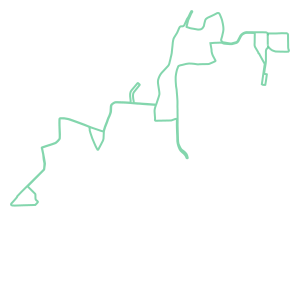

In [134]:
# # To display the route segment

filename = df1['Kode Rute'].iloc[99980]+'.geojson'
gdf_segments = gpd.read_file(f'L2_data/gis split_2/{filename}')
shply_line = gdf_segments.geometry.unary_union

gdf_segments

shply_line

In [145]:
point.head(1)

,New_DO_ID,gpsdatetime,gpsheading,bus_code,Kode Rute,Nama Trip,long_norm,lat_norm,geometry
Index,,,,,,,,,
0,202308080651361886TSW014,2023-08-08 06:59:13,99.0,TSW014,11M,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,106.965748,-6.196192,POINT (717511.138 9314705.016)


In [155]:
# dfprojected[dfprojected['geometry_2'].isna()]
# dfprojected[dfprojected['geometry_2'].isna()==False].iloc[10000:10050]

In [159]:
dfx = df1[df1['Kode Rute']=='8']

In [181]:
# gdf_segments = gpd.read_file(f'L2_data/gis split_2/8.geojson')
# shply_line = gdf_segments.geometry.unary_union

#             # change the GPS data projection system to the one used by the route shapefile
# point = gpd.GeoDataFrame(dfx, geometry=gpd.points_from_xy(dfx['long_norm'], dfx['lat_norm']), crs=pyproj.CRS.from_epsg(4326))
# {'init': 'epsg:4326'}
# #             # change the gps points' projection to the geojson crs system
# point = point.to_crs(gdf_segments.crs)

# point['Index'] = range(len(point))
# point.set_index('Index', inplace=True)

# result = point.copy()
# result['geometry'] = result.apply(lambda row: shply_line.interpolate(shply_line.project( row.geometry)), axis=1)
# result = result.to_crs(4326)
# result['track exist'] = 1

In [186]:
# trial = result[result['New_DO_ID']=='202308080221021323BMP264']
# trial.to_csv('trial_8.csv')

In [183]:
result

#### Main Process of Projection

The function belows is used to reproject/interpolate the rather scattered GPS points so that they follow the route's path

In [199]:
dfprojected = pd.DataFrame()

for i in df1['Kode Rute'].unique():
    dfx = df1[df1['Kode Rute']==i]

        # open the shapefile of the route
    FileName = dfx['Kode Rute'].iloc[0]+'.geojson'
    
    # Reprojecting will only be executed when the shp file for the trip is available
    exist = os.path.isfile(f'L2_data/gis split_2/{FileName}')
    if exist == True:
    
        gdf_segments = gpd.read_file(f'L2_data/gis split_2/{FileName}')
        shply_line = gdf_segments.geometry.unary_union

            # change the GPS data projection system to the one used by the route shapefile
        point = gpd.GeoDataFrame(dfx, geometry=gpd.points_from_xy(dfx['long_norm'], dfx['lat_norm']), crs=pyproj.CRS.from_epsg(4326))
        {'init': 'epsg:4326'}
            # change the gps points' projection to the geojson crs system
        point = point.to_crs(gdf_segments.crs)

        point['Index'] = range(len(point))
        point.set_index('Index', inplace=True)

        result = point.copy()
        result['geometry'] = result.apply(lambda row: shply_line.interpolate(shply_line.project( row.geometry)), axis=1)
        result = result.to_crs(4326)
        result['track exist'] = 1

        dfprojected = pd.concat([dfprojected, result])
        
        
    else:
        point = gpd.GeoDataFrame(dfx, geometry=gpd.points_from_xy(dfx['long_norm'], dfx['lat_norm']), crs=pyproj.CRS.from_epsg(4326))
        {'init': 'epsg:4326'}
            # reproject the points
        point = point.to_crs(gdf_segments.crs)
        point['Index'] = range(len(point))
        point.set_index('Index', inplace=True)
        result = point.copy()
        result = result.to_crs(4326)
        result['track exist'] = 0
        dfprojected = pd.concat([dfprojected, result])

In [188]:
result

,New_DO_ID,gpsdatetime,gpsheading,bus_code,Kode Rute,Nama Trip,long_norm,lat_norm,geometry,track exist
Index,,,,,,,,,,
0,202308080221021323BMP264,2023-08-08 05:16:56,285.0,BMP264,8,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773660,-6.289395,POINT Z (106.77366 -6.28934 0.00000),1
1,202308080221021323BMP264,2023-08-08 05:16:58,284.0,BMP264,8,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773627,-6.289385,POINT Z (106.77363 -6.28933 0.00000),1
2,202308080221021323BMP264,2023-08-08 05:17:00,283.0,BMP264,8,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773583,-6.289373,POINT Z (106.77359 -6.28933 0.00000),1
3,202308080221021323BMP264,2023-08-08 05:17:03,278.0,BMP264,8,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773500,-6.289357,POINT Z (106.77350 -6.28932 0.00000),1
4,202308080221021323BMP264,2023-08-08 05:17:06,280.0,BMP264,8,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773378,-6.289332,POINT Z (106.77338 -6.28931 0.00000),1
...,...,...,...,...,...,...,...,...,...,...
38,202308080726531164TSW014,2023-08-08 09:39:16,99.0,TSW014,11M,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,106.965805,-6.196135,POINT Z (106.96582 -6.19614 0.00000),1
39,202308080726531164TSW014,2023-08-08 09:39:18,99.0,TSW014,11M,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,106.965813,-6.196133,POINT Z (106.96582 -6.19614 0.00000),1
40,202308080726531164TSW014,2023-08-08 09:39:21,99.0,TSW014,11M,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,106.965815,-6.196128,POINT Z (106.96582 -6.19613 0.00000),1


In [200]:
dfprojected.to_csv('TrialOutputs/20230927_dfprojected_all_8 Agus_Pagi.csv')
#

In [138]:
# dfprojected = pd.read_csv('TrialOutputs/20230927_dfprojected_all_8 Agus_Pagi.csv')

In [258]:
len(df1), len(dfprojected)

(3977607, 3977607)

In [259]:
dfprojected.head(5)

,New_DO_ID,gpsdatetime,gpsheading,bus_code,Kode Rute,Kode Trip,Nama Trip,long_norm,lat_norm,geometry,track exist
Index,,,,,,,,,,,
0,202308080221021323BMP264,2023-08-08 05:16:56,285.0,BMP264,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773660,-6.289395,POINT Z (106.77366 -6.28934 0.00000),1
1,202308080221021323BMP264,2023-08-08 05:16:58,284.0,BMP264,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773627,-6.289385,POINT Z (106.77363 -6.28933 0.00000),1
2,202308080221021323BMP264,2023-08-08 05:17:00,283.0,BMP264,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773583,-6.289373,POINT Z (106.77359 -6.28933 0.00000),1
3,202308080221021323BMP264,2023-08-08 05:17:03,278.0,BMP264,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773500,-6.289357,POINT Z (106.77350 -6.28932 0.00000),1
4,202308080221021323BMP264,2023-08-08 05:17:06,280.0,BMP264,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.773378,-6.289332,POINT Z (106.77338 -6.28931 0.00000),1


In [191]:
dfprojected['projected_points'] = dfprojected['geometry']
# dfprojected['original_points'] = dfprojected['geometry_2']

In [142]:
# dfprojected[(dfprojected['track exist']==1) &( dfprojected['bus_code']=='BMP264')].to_csv('0927_trial1.csv')

### B. Find the GPS points that are within a certain radius of a stop

- Menggunakan buffer dan sjoin geopandas
- Setelah dijoin baru ditandai yg mana yg looping
- Baru nanti dicocokan dengan stops sequence. diproses per DO ID aja dulu, 
- Untuk yang looping dipisahkan dijadikan trip baru setelah a certain stops sequence

In [337]:
dfstopseq = pd.read_excel('Agustus-8/Modified_Stop Seq 8 Agustus_Updated.xlsx')
dfstopseq.head(2)

,ID,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Stop ID,Nama Perhentian,Koordinat,Latitude,Longitude,Urutan,Keterangan,Tipe Perhentian,Kategori Rute,split,Looping,Destination,Origin,Alt Nama Trip
0,1,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00026C,KOTA,-6.13782,106.81387,-6.13782,1,PERGI,Halte,BRT,2,One Trip,HARMONI,KOTA,KOTA-HARMONI
1,2,1,BLOK M - KOTA,1-P01,KOTA-HARMONI,H00068P,GLODOK,-6.14450,106.81545,-6.14450,2,PERGI,Halte,BRT,2,One Trip,HARMONI,KOTA,KOTA-HARMONI


In [339]:
kt = list(dfstopseq['Kode Trip'].unique())
dfprojected[dfprojected['Kode Trip'].isin(kt)==False]

,New_DO_ID,gpsdatetime,gpsheading,bus_code,Kode Rute,Kode Trip,Nama Trip,long_norm,lat_norm,geometry,track exist
Index,,,,,,,,,,,


In [346]:
# dfprojected.to_csv('Agustus-8/GPS Points and Trips.csv')

In [347]:
dfstopseq['Longitude'] = dfstopseq['Latitude']
dfstopseq['Latitude'] = dfstopseq['Koordinat']

In [350]:
dfstopseq.head(2)
print(dfstopseq['Longitude'].unique()[1:5])
print(dfstopseq['Latitude'].unique()[1:5])

[106.81545 106.81669 106.81736 106.81922]
[-6.1445  -6.1493  -6.15217 -6.16041]


#### 1) Identify if the points are within a radius of a Halte/Bus Stop

<b>Input:</b>
- Modified stops sequence
- Matched driving order (trip-id included) and GPS data
- Preffered radius in meters (first trial: 20 m)

<b>Output:</b>
- GPS Data with trip history but only for the points that are within a radius of a Halte

In [351]:
def matchhalte (dfstops, dfgps, radius):
    df=pd.DataFrame()
    for i in dfgps['Kode Trip'].unique(): 
        dfs = dfstops[dfstops['Kode Trip']==i] #Choosing the corresponding stops sequence based on Kode Trip
        dfg = dfgps[dfgps['Kode Trip']==i]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs['Longitude'], dfs['Latitude']), crs=pyproj.CRS.from_epsg(4326))
        gdfg = gpd.GeoDataFrame(dfg, geometry='geometry')#can only be used if the projection phase was executed
        gdfg.to_crs(gdfs.crs)
        # IF NOT PROJECTED: gdfg = gpd.GeoDataFrame(dfg, geometry=gpd.points_from_xy(dfg['gpslon'], dfg['gpslat']), crs=pyproj.CRS.from_epsg(4326))
        for gdf in [gdfs, gdfg]:
            gdf.to_crs(pyproj.CRS.from_epsg(3857), inplace=True)
        gdfs['geometry'] = gdfs['geometry'].buffer(radius) # Create buffer around the bus stops
        gdf = gpd.sjoin(gdfs, gdfg, how='left') # Spatial join between the buffer and the projected gps data points
        df = pd.concat([df, gdf])
    return df

In [617]:
dfprojected['projected points'] = dfprojected['geometry']

In [352]:
start = time.time()

processed_gps = matchhalte (dfstopseq, dfprojected, 20)

In [353]:
#start = time.time()
end = time.time()
(end - start)

63.871535539627075

In [615]:
# processed_gps[processed_gps['New_DO_ID'].isna()]

In [354]:
processed_gps  = processed_gps.drop(["index_right", "Koordinat", "Urutan", "Kategori Rute", "Kode Trip_left", "Nama Trip_left"], axis=1)
processed_gps  = processed_gps.dropna(subset='New_DO_ID')
processed_gps['ID'] = list(range(len(processed_gps)))
processed_gps.set_index('ID', inplace=True)
processed_gps.head(5)

,Kode Rute_left,Nama Rute,Stop ID,Nama Perhentian,Latitude,Longitude,Keterangan,Tipe Perhentian,split,Looping,Destination,Origin,Alt Nama Trip,geometry,New_DO_ID,gpsdatetime,gpsheading,bus_code,Kode Rute_right,Kode Trip_right,Nama Trip_right,long_norm,lat_norm,track exist
ID,,,,,,,,,,,,,,,,,,,,,,,,
0,8,LEBAK BULUS - PASAR BARU,H00122P,LEBAK BULUS,-6.28938,106.774076,PERGI,Halte,3,1,PASAR BARU,LEBAK BULUS,LEBAK BULUS-PASAR BARU,"POLYGON ((11886055.770 -701540.871, 11886055.6...",202308080749051937BMP277,2023-08-08 10:52:56,87.0,BMP277,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.774200,-6.289503,1.0
1,8,LEBAK BULUS - PASAR BARU,H00122P,LEBAK BULUS,-6.28938,106.774076,PERGI,Halte,3,1,PASAR BARU,LEBAK BULUS,LEBAK BULUS-PASAR BARU,"POLYGON ((11886055.770 -701540.871, 11886055.6...",202308080749051937BMP277,2023-08-08 10:53:54,87.0,BMP277,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.774192,-6.289582,1.0
2,8,LEBAK BULUS - PASAR BARU,H00122P,LEBAK BULUS,-6.28938,106.774076,PERGI,Halte,3,1,PASAR BARU,LEBAK BULUS,LEBAK BULUS-PASAR BARU,"POLYGON ((11886055.770 -701540.871, 11886055.6...",202308080749051937BMP277,2023-08-08 10:52:39,87.0,BMP277,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.774192,-6.289573,1.0
3,8,LEBAK BULUS - PASAR BARU,H00122P,LEBAK BULUS,-6.28938,106.774076,PERGI,Halte,3,1,PASAR BARU,LEBAK BULUS,LEBAK BULUS-PASAR BARU,"POLYGON ((11886055.770 -701540.871, 11886055.6...",202308080749051937BMP277,2023-08-08 10:53:56,87.0,BMP277,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.774195,-6.289533,1.0
4,8,LEBAK BULUS - PASAR BARU,H00122P,LEBAK BULUS,-6.28938,106.774076,PERGI,Halte,3,1,PASAR BARU,LEBAK BULUS,LEBAK BULUS-PASAR BARU,"POLYGON ((11886055.770 -701540.871, 11886055.6...",202308080736021747BMP288,2023-08-08 10:39:56,276.0,BMP288,8,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,106.774208,-6.289387,1.0


In [355]:
len(processed_gps), len(dfprojected)

(609844, 3977607)

In [358]:
len(processed_gps['New_DO_ID'].unique()), len(dfprojected['New_DO_ID'].unique())

(3935, 3947)

In [252]:
# dfprojected.head(2)

In [359]:
len(processed_gps['bus_code'].unique()), len(dfprojected['bus_code'].unique())

(1389, 1392)

In [360]:
processed_gps.groupby(['Kode Rute_right']).nunique()[['New_DO_ID', 'bus_code']].sort_values(['New_DO_ID'], ascending=False)

,New_DO_ID,bus_code
Kode Rute_right,,
1,175,64
7,145,29
9,140,70
10,132,35
5,131,23
...,...,...
10ST,2,2
11M,2,1
12A,2,1


#### 2) Identify which points in a trip belong to which halte

In [497]:
#d f[(df['New_DO_ID']==do)]
df.loc[(df['New_DO_ID']==do) & (df['Keterangan']=='PERGI')]['Urutan'].max()

32

In [499]:
dfq['Urutan'].iloc[h] == dfq[dfq['Keterangan']=='PERGI']['Urutan'].max()

True

In [80]:
#dfstopseq[dfstopseq['Kode Trip']=='7-R01']

In [ ]:
start = time.time()

df = pd.DataFrame()
for do in list(trialkor13['New_DO_ID'].unique()):
    dfo = trialkor13[trialkor13['New_DO_ID']==do]
    dfq = dfstopseq[dfstopseq['Kode Trip']==dfo['Kode Trip_right'].iloc[0]]
    loop = dfo['Looping'].iloc[0]
    #t0 = dfo['Gpsdatetime'].min()
    for h in range(len(dfq)):
        if dfq['Keterangan'].iloc[h] == 'PERGI':
            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte]
            if len(dfo2)>0:
                dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].min()].iloc[[0]]
                dfanswer0 = pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 'lat_norm': dfanswer['lat_norm'].iloc[0] }, index = [1])
                df = pd.concat([df, dfanswer0])

            else:
                dfnan =  pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999 }, index = [1])
                df = pd.concat([df, dfnan])
                
                
        elif dfq['Keterangan'].iloc[h] == 'PULANG':
            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte]
            if len(dfo2)>0:
                dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].max()].iloc[[0]]
                dfanswer0 = pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 'lat_norm': dfanswer['lat_norm'].iloc[0] }, index = [1])
                df = pd.concat([df, dfanswer0])

            else:
                dfnan =  pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999 }, index = [1])
                df = pd.concat([df, dfnan])
 

In [368]:
processed_gps.head(1)
processed_gps.rename(columns={'gpsdatetime': 'Gpsdatetime', 'gpsheading': 'Gpsheading', 'bus_code': 'Bus Code' },inplace=True)

In [371]:
start = time.time()

df = pd.DataFrame()
for do in list(processed_gps['New_DO_ID'].unique()): # iterate per DO
    dfo = processed_gps[processed_gps['New_DO_ID']==do]  # call only the intersected gps data belonging to the DO being called 
    dfq = dfstopseq[dfstopseq['Kode Trip']==dfo['Kode Trip_right'].iloc[0]] # call the stops sequence for the trip-id used in the DO
    tn = dfq[dfq['Keterangan']=='PERGI']['Urutan'].max() # turning point for a looping trip
    loop = dfo['Looping'].iloc[0] # identify if the trip is looping 
    #t0 = dfo['Gpsdatetime'].min()
    for h in range(len(dfq)): # iterate per halte/stop in the stops sequence 
        # Treatment is different for trip PERGI and trip PULANG. If it's not a looping trip it will only use the trip PERGI algortihm. 
        
        if dfq['Keterangan'].iloc[h] == 'PERGI':
            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte] # call the DO's gps points that have been identied as being within the Halte's radius
            if len(dfo2)>0: #if there are points identified near the halte: 
                dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].min()].iloc[[0]]
                dfanswer0 = pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  
                                          'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 
                                          'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 
                                          'lat_norm': dfanswer['lat_norm'].iloc[0]}, index = [1])
                df = pd.concat([df, dfanswer0])

            else: # if not found. return nan for each column
                dfnan =  pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] , 
                                       'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 
                                       'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                       'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999 }, index = [1])
                df = pd.concat([df, dfnan])
                
                
        elif dfq['Keterangan'].iloc[h] == 'PULANG':
            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte]
            if len(dfo2)>0:
                dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].max()].iloc[[0]] # only use the max time point. Dangerous for open end time
                dfanswer0 = pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  
                                          'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 'lat_norm': dfanswer['lat_norm'].iloc[0]}, index = [1])
                df = pd.concat([df, dfanswer0])

            else:
                dfnan =  pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] , 
                                       'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 
                                       'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999  }, index = [1])
                df = pd.concat([df, dfnan])
 

In [503]:
start = time.time()

df_del = pd.DataFrame()
for do in list(processed_gps['New_DO_ID'].unique()): # iterate per DO
    dfo = processed_gps[processed_gps['New_DO_ID']==do]  # call only the intersected gps data belonging to the DO being called 
    dfq = dfstopseq[dfstopseq['Kode Trip']==dfo['Kode Trip_right'].iloc[0]] # call the stops sequence for the trip-id used in the DO
    tn = dfq[dfq['Keterangan']=='PERGI']['Urutan'].max() # turning point for a looping trip
    loop = dfo['Looping'].iloc[0] # identify if the trip is looping 
    #t0 = dfo['Gpsdatetime'].min()
    for h in range(len(dfq)): # iterate per halte/stop in the stops sequence 
        # Treatment is different for trip PERGI and trip PULANG. If it's not a looping trip it will only use the trip PERGI algortihm. 
        
        if dfq['Keterangan'].iloc[h] == 'PERGI':
            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte] # call the DO's gps points that have been identied as being within the Halte's radius
            if len(dfo2)>0: #if there are points identified near the halte: 
                dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].min()].iloc[[0]]
                dfanswer0 = pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 'lat_norm': dfanswer['lat_norm'].iloc[0]}, index = [1])
                df_del = pd.concat([df_del, dfanswer0])
                
                if dfq['Urutan'].iloc[h] == dfq[dfq['Keterangan']=='PERGI']['Urutan'].max():
                    dfo = dfo.loc[dfo['Gpsdatetime'] >= dfanswer['Gpsdatetime'].iloc[0]]
                    deleted = True

            else: # if not found. return nan for each column
                dfnan =  pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999 }, index = [1])
                df_del = pd.concat([df_del, dfnan])
                
           
                
        elif dfq['Keterangan'].iloc[h] == 'PULANG':

            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte]
            if len(dfo2)>0:
                if deleted: 
                     dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].max()].iloc[[0]]
                else: 
                    dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].max()].iloc[[0]] # only use the max time point. Dangerous for open end time
                dfanswer0 = pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 'lat_norm': dfanswer['lat_norm'].iloc[0]}, index = [1])
                df_del = pd.concat([df_del, dfanswer0])

            else:
                dfnan =  pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999  }, index = [1])
                df_del = pd.concat([df_del, dfnan])
 

In [432]:
start = time.time()

dlist = []
for do in list(processed_gps['New_DO_ID'].unique()): # iterate per DO
    dfo = processed_gps[processed_gps['New_DO_ID']==do]  # call only the intersected gps data belonging to the DO being called 
    dfq = dfstopseq[dfstopseq['Kode Trip']==dfo['Kode Trip_right'].iloc[0]] # call the stops sequence for the trip-id used in the DO
    tn = dfq[dfq['Keterangan']=='PERGI']['Urutan'].max() # turning point for a looping trip
    loop = dfo['Looping'].iloc[0] # identify if the trip is looping 
    #t0 = dfo['Gpsdatetime'].min()
    for h in range(len(dfq)): # iterate per halte/stop in the stops sequence 
        # Treatment is different for trip PERGI and trip PULANG. If it's not a looping trip it will only use the trip PERGI algortihm. 
        
        if dfq['Keterangan'].iloc[h] == 'PERGI':
            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte] # call the DO's gps points that have been identied as being within the Halte's radius
            if len(dfo2)>0: #if there are points identified near the halte: 
                dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].min()].iloc[[0]]
                dfanswer0 = {'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 'lat_norm': dfanswer['lat_norm'].iloc[0]}
                dlist.append(dfanswer0)

            else: # if not found. return nan for each column
                dfnan = {'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999 }
                dlist.append(dfnan)
                
                
        elif dfq['Keterangan'].iloc[h] == 'PULANG':
            
            halte = dfq['Nama Perhentian'].iloc[h]
            dfo2 = dfo[dfo['Nama Perhentian']==halte]
            if len(dfo2)>0:
                dfanswer = dfo2[dfo2['Gpsdatetime']==dfo2['Gpsdatetime'].max()].iloc[[0]] # only use the max time point. Dangerous for open end time
                dfanswer0 = {'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                           'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                'Gpsdatetime': dfanswer['Gpsdatetime'].iloc[0], 'Gpsheading': dfanswer['Gpsheading'].iloc[0],
                                'long_norm': dfanswer['long_norm'].iloc[0] , 'lat_norm': dfanswer['lat_norm'].iloc[0]}
                dlist.append(dfanswer0)

            else:
                dfnan =  pd.DataFrame({'New_DO_ID': do ,  'Bus Code': dfo['Bus Code'].iloc[0] ,  'Kode Rute': dfq.iloc[h]['Kode Rute'] , 'Nama Rute':dfq.iloc[h]['Nama Rute'], 
                                          'Kode Trip_right':dfo['Kode Trip_right'].iloc[0] , 'Nama Trip': dfo['Nama Trip_right'].iloc[0] ,
                                        'Looping': dfq.iloc[h]['Looping'], 'Alt Nama Trip': dfq.iloc[h]['Alt Nama Trip'], 
                                         'Stop ID': dfq.iloc[h]['Stop ID'] , 'Nama Perhentian': dfq.iloc[h]['Nama Perhentian'] , 
                                       'Urutan': dfq.iloc[h]['Urutan'], 'Keterangan': dfq.iloc[h]['Keterangan'],
                                          'Latitude': dfq.iloc[h]['Latitude'] , 'Longitude': dfq.iloc[h]['Longitude'],'geometry': dfanswer['geometry'].iloc[0],
                                'Gpsdatetime': 9999, 'Gpsheading': 9999,
                                'long_norm':9999, 'lat_norm': 9999  }, index = [1])
                dlist.append(dfnan)
 

In [504]:
end = time.time()
(end - start)/60

37.62051774660746

In [515]:
df

,New_DO_ID,Bus Code,Kode Rute,Nama Rute,Kode Trip_right,Nama Trip,Looping,Alt Nama Trip,Stop ID,Nama Perhentian,Latitude,Longitude,geometry,Urutan,Keterangan,Gpsdatetime,Gpsheading,long_norm,lat_norm
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00122P,LEBAK BULUS,-6.289380,106.774076,POLYGON ((11886055.770242292 -701540.871127376...,1,PERGI,2023-08-08 10:52:29,87.0,106.774230,-6.289628
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00179P,PONDOK PINANG,-6.282128,106.772028,POLYGON ((11885827.787925148 -700728.699573978...,2,PERGI,2023-08-08 08:03:46,6.0,106.771992,-6.282260
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00177P,PONDOK INDAH 1,-6.286762,106.779952,POLYGON ((11886709.883570194 -701247.672754725...,3,PERGI,2023-08-08 08:08:11,46.0,106.779890,-6.286822
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00178P,PONDOK INDAH 2,-6.267224,106.783614,POLYGON ((11887117.53554548 -699059.5948722223...,4,PERGI,2023-08-08 08:16:38,360.0,106.783590,-6.267300
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00237P,TANAH KUSIR KODIM,-6.256997,106.781676,POLYGON ((11886901.798372323 -697914.296794052...,5,PERGI,2023-08-08 08:19:09,0.0,106.781668,-6.257152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,202308080651361886TSW014,TSW014,11M,RUSUN RAWA BEBEK - BUKIT DURI,11M-L01,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,1,RUSUN RAWA BEBEK-BUKIT DURI,H00055P,FLYOVER RADIN INTEN,-6.215982,106.924380,"POLYGON ((11907398.388295142 -691110.83369023,...",28,PERGI,9999,9999.0,9999.000000,9999.000000
1,202308080651361886TSW014,TSW014,11M,RUSUN RAWA BEBEK - BUKIT DURI,11M-L01,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,1,RUSUN RAWA BEBEK-BUKIT DURI,H00168P,PERUMNAS KLENDER,-6.216689,106.930540,"POLYGON ((11907398.388295142 -691110.83369023,...",29,PERGI,9999,9999.0,9999.000000,9999.000000
1,202308080651361886TSW014,TSW014,11M,RUSUN RAWA BEBEK - BUKIT DURI,11M-L01,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,1,RUSUN RAWA BEBEK-BUKIT DURI,H00163P,PENGGILINGAN,-6.214132,106.939610,"POLYGON ((11907398.388295142 -691110.83369023,...",30,PERGI,9999,9999.0,9999.000000,9999.000000
1,202308080651361886TSW014,TSW014,11M,RUSUN RAWA BEBEK - BUKIT DURI,11M-L01,RUSUN RAWA BEBEK-BUKIT DURI-RUSUN RAWA BEBEK,1,RUSUN RAWA BEBEK-BUKIT DURI,H00259P,WALIKOTA JAKARTA TIMUR,-6.212540,106.945370,"POLYGON ((11907398.388295142 -691110.83369023,...",31,PERGI,9999,9999.0,9999.000000,9999.000000


#### 3) Cleaning the result

In [481]:
print (len(df))
df.head(1)

117119


,New_DO_ID,Bus Code,Kode Rute,Nama Rute,Kode Trip_right,Nama Trip,Looping,Alt Nama Trip,Stop ID,Nama Perhentian,Latitude,Longitude,geometry,Urutan,Keterangan,Gpsdatetime,Gpsheading,long_norm,lat_norm
1,202308080749051937BMP277,BMP277,8,LEBAK BULUS - PASAR BARU,8-L02,LEBAK BULUS-PASAR BARU-LEBAK BULUS,1,LEBAK BULUS-PASAR BARU,H00122P,LEBAK BULUS,-6.28938,106.774076,POLYGON ((11886055.770242292 -701540.871127376...,1,PERGI,2023-08-08 10:52:29,87.0,106.77423,-6.289628


In [395]:
dfbackup = df.copy()
dfbackup.to_csv('Agustus-8/GPS Processed Uncleaned_20230808_Pagi.csv')

In [375]:
df.sort_values(by=['New_DO_ID', 'Urutan'], inplace=True, ascending=True)
df['idx'] = list(range(len(df)))
df.set_index('idx', inplace=True)

In [376]:
df = dfbackup.copy()

In [377]:
df['Gpsdatetime'] = df['Gpsdatetime'].fillna(9999)

In [382]:
len(df['New_DO_ID'].unique()), len(dftrip['New_DO_ID'])

(3935, 3947)

In [751]:
# dfcleaning[['Alt Nama Trip', 'Nama Perhentian', 'Urutan', 'Gpsdatetime', 'Keterangan']]

<b>Final Script u/ Membersihkan</b>

In [742]:
dfc1 = pd.DataFrame()

DO_list = list(df['New_DO_ID'].unique())

df.sort_values(by=['New_DO_ID', 'Urutan'], ascending=True, inplace=True)

for DO in DO_list:
    dfcleaning = df[df['New_DO_ID']==DO]
    dfcleaning['idx'] = range(len(dfcleaning))
    
    ## Urutan 1: 
    if dfcleaning.loc[(dfcleaning['Urutan']==1)]['Gpsdatetime'].iloc[0] != 9999:
        if dfcleaning.loc[dfcleaning['Urutan']==1]['Gpsdatetime'].iloc[0] !=  dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime'].min():
            dfcleaning.loc[dfcleaning['Urutan']==1, 'Gpsdatetime'] = 9999
    
    ## Find the gps datetime at the last stop (PERGI) and make sure all PERGI is before that, while all PULANG is after that
    if len(dfcleaning.loc[(dfcleaning['Keterangan']=='PERGI')  & (dfcleaning['Gpsdatetime']!= 9999)])>0:
        maxpergi = dfcleaning.loc[dfcleaning['Urutan'] == dfcleaning.loc[(dfcleaning['Keterangan']=='PERGI') & (dfcleaning['Gpsdatetime']!= 9999)]['Urutan'].max()]['Gpsdatetime'].iloc[0]
        
        if len(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PERGI') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']>maxpergi)])>0:
            list9 = list(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PERGI') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']>maxpergi)]['idx'])
            dfcleaning.loc[dfcleaning['idx'].isin(list9), 'Gpsdatetime'] = 9999
        
        if len(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PULANG') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']<maxpergi)])>0:
            list9 = list(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PULANG') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']<maxpergi)]['idx'])
            dfcleaning.loc[dfcleaning['idx'].isin(list9), 'Gpsdatetime'] = 9999
    
    elif len(dfcleaning.loc[(dfcleaning['Keterangan']=='PULANG')  & (dfcleaning['Gpsdatetime']!= 9999)])>0:
        minpulang = dfcleaning.loc[dfcleaning['Urutan'] == dfcleaning.loc[(dfcleaning['Keterangan']=='PULANG') & (dfcleaning['Gpsdatetime']!= 9999)]['Urutan'].min()]['Gpsdatetime'].iloc[0]
        
        if len(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PERGI') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']>minpulang)])>0:
            list9 = list(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PERGI') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']>minpulang)]['idx'])
            dfcleaning.loc[dfcleaning['idx'].isin(list9), 'Gpsdatetime'] = 9999
        
        if len(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PULANG') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']<minpulang)])>0:
            list9 = list(dfcleaning[dfcleaning['Gpsdatetime']!=9999].loc[(dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Keterangan']=='PULANG') & (dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime']<minpulang)]['idx'])
            dfcleaning.loc[dfcleaning['idx'].isin(list9), 'Gpsdatetime'] = 9999
            
            
    if dfcleaning.loc[(dfcleaning['Urutan']==dfcleaning['Urutan'].max())]['Gpsdatetime'].iloc[0] != 9999: 
         if dfcleaning.loc[dfcleaning['Urutan']==dfcleaning['Urutan'].max()]['Gpsdatetime'].iloc[0] !=  dfcleaning[dfcleaning['Gpsdatetime']!=9999]['Gpsdatetime'].max():
            dfcleaning.loc[dfcleaning['Urutan']==dfcleaning['Urutan'].max(), 'Gpsdatetime'] = 9999
    
    dfc1 = pd.concat([dfc1, dfcleaning])
        
        

In [746]:
# RESULT

print(len(dfc1), len(df))

print(len(df[df['Gpsdatetime']==9999]), len(dfc1[dfc1['Gpsdatetime']==9999]))

print(len(dfc1[dfc1['Gpsdatetime']==9999])/ len(df))

115643 115643
18614 26250
0.2269916899423225


In [750]:
# dfc1[dfc1['New_DO_ID']=='202308080352151090MB1641'][['Urutan', 'Nama Perhentian', 'Keterangan', 'Gpsdatetime']]

In [768]:
dfc1.columns

dfc2 = dfc1[['New_DO_ID', 'Bus Code', 'Kode Rute', 'Nama Rute', 'Kode Trip_right',
       'Nama Trip', 'Looping', 'Alt Nama Trip', 'Stop ID', 'Nama Perhentian', 'Urutan', 'Keterangan',
       'Gpsdatetime', 'long_norm', 'lat_norm']] #'projected points']]

dfc2.rename(columns={'Kode Trip_right': 'Kode Trip'}, inplace=True)
             

C:\Users\Nadya\AppData\Local\Temp\ipykernel_20516\2498969463.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc2.rename(columns={'Kode Trip_right': 'Kode Trip'}, inplace=True)


In [753]:
dfc2.to_csv('Agustus-8/GPS Cleaned Result_8 Agustus Pagi.csv')

## 3. Evaluation

In [754]:
df999 = dfc2.groupby(['New_DO_ID'])[['Gpsdatetime']].apply(lambda x: x[x == 9999].count()).reset_index()
dfall = dfc2.groupby(['New_DO_ID', 'Kode Rute'])[['Gpsdatetime']].count().reset_index()

dev = dfall.merge(df999, how='left', on='New_DO_ID')
dev.rename(columns={'Gpsdatetime_x': 'Jumlah Stops Sequence', 'Gpsdatetime_y': 'Jumlah 9999'}, inplace=True)
dev['% GPS Found'] = (dev['Jumlah Stops Sequence'] - dev['Jumlah 9999'])/dev['Jumlah Stops Sequence'] 
dev['% GPS Found'] = dev['% GPS Found'].apply(lambda x: round(x, 2)) 

In [755]:
dev['% GPS Found'].describe()

count    3917.000000
mean        0.781933
std         0.225755
min         0.010000
25%         0.750000
50%         0.860000
75%         0.930000
max         1.000000
Name: % GPS Found, dtype: float64

In [756]:
dev['% GPS Found_2'] = dev['% GPS Found']*100

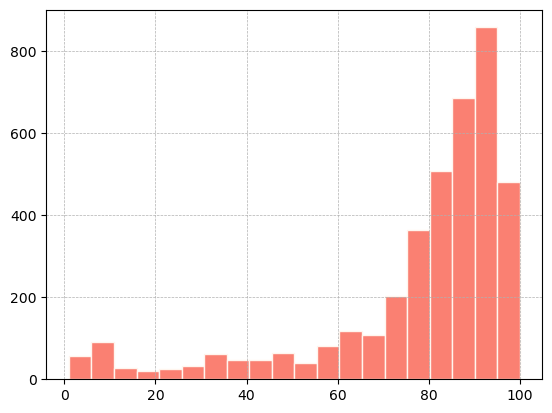

In [760]:
plt.hist(dev['% GPS Found_2'], bins=20, color='salmon', edgecolor= 'seashell')
plt.grid(which='both', linestyle='--', linewidth=0.5)

In [761]:
dev.groupby('Kode Rute').mean()[['% GPS Found_2']].to_excel('Evaluasi Rata2-2.xlsx')

In [762]:
dev[dev['% GPS Found_2']==100]

,New_DO_ID,Kode Rute,Jumlah Stops Sequence,Jumlah 9999,% GPS Found,% GPS Found_2
4,202308080229471823PPD0760,5C,41,0,1.0,100.0
16,202308080258351123TSW098,11D,32,0,1.0,100.0
25,202308080305081408MYS18122,6V,30,0,1.0,100.0
60,202308080330161484MYS18129,6V,30,0,1.0,100.0
66,202308080335361817TJ0284,9N,6,0,1.0,100.0
...,...,...,...,...,...,...
3837,202308081037541882SAF111,4,16,0,1.0,100.0
3851,202308081043201630MYS18201,6B,17,0,1.0,100.0
3882,202308081055341217MYS19203,3,11,0,1.0,100.0
3905,202308081106371871MYS21323,1F,14,0,1.0,100.0


## 4. Find Duration

In [878]:
dfd = dfc2[dfc2['Kode Rute']=='6V']

dfd['Alt Nama Trip'].unique()

df_duration = pd.DataFrame()

for do in dfd['New_DO_ID'].unique():
    dfd2 = dfd[dfd['New_DO_ID']== do]
    for i in range(dfd2['Urutan'].min(), dfd2['Urutan'].max()):
        origin = dfd2[dfd2['Urutan']==i]['Nama Perhentian'].iloc[0]
        destination = dfd2[dfd2['Urutan']==i+1]['Nama Perhentian'].iloc[0]
        segment =  (f'{origin} - {destination}')
        
        if dfd2[dfd2['Urutan']==i]['Gpsdatetime'].iloc[0]!=9999:
            jam = dfd2[dfd2['Urutan']==i]['Gpsdatetime'].iloc[0].hour
            if  dfd2[dfd2['Urutan']==i+1]['Gpsdatetime'].iloc[0]!=9999:
                duration = round((dfd2[dfd2['Urutan']==i+1]['Gpsdatetime'].iloc[0] - dfd2[dfd2['Urutan']==i]['Gpsdatetime'].iloc[0]).total_seconds()/60, 2)
        else:
            duration = 'not found'
            jam = dfd2[dfd2['Gpsdatetime']!=9999]['Gpsdatetime'].min().hour

        df_duration = pd.concat([df_duration, pd.DataFrame({'Trip' : dfd2['Nama Trip'].iloc[0], 'Hour': jam,  'Segment': segment, 
                                                            'Duration (min)': duration, 'New_DO_ID': do, 'Urutan': round(i, 0) }, index=[i])])

        
        

In [841]:
# dfd[dfd['New_DO_ID']=='202308080953551302PPD0717']

In [837]:
dfd[dfd['Gpsdatetime']!=9999]['Gpsdatetime'].max()

Timestamp('2023-08-08 11:44:00')

In [887]:
df_duration['Duration (min)'].min()

0.87

In [888]:
df_duration = df_duration[df_duration['Duration (min)']!= 'not found']
duration_grouped = df_duration.groupby(['Urutan', 'Segment','Hour']).median().reset_index()
duration_grouped

C:\Users\Nadya\AppData\Local\Temp\ipykernel_20516\2842948762.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.median is deprecated. In a future version, a TypeError will be raised. Before calling .median, select only columns which should be valid for the function.
  duration_grouped = df_duration.groupby(['Urutan', 'Segment','Hour']).median().reset_index()


,Urutan,Segment,Hour,Duration (min)
0,1,RAGUNAN - DEPARTEMEN PERTANIAN,5,2.650
1,1,RAGUNAN - DEPARTEMEN PERTANIAN,6,2.920
2,1,RAGUNAN - DEPARTEMEN PERTANIAN,7,2.810
3,1,RAGUNAN - DEPARTEMEN PERTANIAN,8,2.940
4,1,RAGUNAN - DEPARTEMEN PERTANIAN,9,3.230
...,...,...,...,...
171,29,DEPARTEMEN PERTANIAN - RAGUNAN,7,9.750
172,29,DEPARTEMEN PERTANIAN - RAGUNAN,8,10.225
173,29,DEPARTEMEN PERTANIAN - RAGUNAN,9,5.300
174,29,DEPARTEMEN PERTANIAN - RAGUNAN,10,8.495


In [889]:
duration_grouped.to_excel('duration_trial_6v.xlsx')

In [869]:
df_duration['Segment'].unique()

array(['ASMI - PEDONGKELAN', 'PEDONGKELAN - CEMPAKA TIMUR',
       'CEMPAKA TIMUR - RS ISLAM', 'RS ISLAM - CEMPAKA TENGAH',
       'CEMPAKA TENGAH - PASAR CEMPAKA PUTIH',
       'PASAR CEMPAKA PUTIH - RAWA SELATAN', 'RAWA SELATAN - GALUR',
       'GALUR - SENEN', 'SENEN - ATRIUM', 'ATRIUM - RSPAD',
       'RSPAD - DEPLU', 'DEPLU - GAMBIR 1', 'GAMBIR 1 - ISTIQLAL',
       'ISTIQLAL - JUANDA', 'PECENONGAN - MONAS', 'MONAS - MONAS',
       'MONAS - BALAI KOTA', 'BALAI KOTA - GAMBIR 2',
       'GAMBIR 2 - KWITANG', 'KWITANG - SENEN', 'SENEN - GALUR',
       'GALUR - RAWA SELATAN', 'RAWA SELATAN - PASAR CEMPAKA PUTIH',
       'PASAR CEMPAKA PUTIH - CEMPAKA TENGAH',
       'CEMPAKA TENGAH - RS ISLAM', 'RS ISLAM - CEMPAKA TIMUR',
       'CEMPAKA TIMUR - PEDONGKELAN', 'PEDONGKELAN - ASMI',
       'ASMI - BERMIS', 'BERMIS - PULO GADUNG 1', 'BERMIS - ASMI',
       'JUANDA - PECENONGAN', 'PULO GADUNG 1 - BERMIS'], dtype=object)

In [892]:
# dfd[(dfd['Nama Perhentian']=='BERMIS') & (dfd['Gpsdatetime']==9999)]
# dfd[(dfd['Urutan']==2 ) & (dfd['Gpsdatetime']!=9999)]

# dfd[dfd['New_DO_ID']=='202308080259281592MYS18112']

dfd

,New_DO_ID,Bus Code,Kode Rute,Nama Rute,Kode Trip,Nama Trip,Looping,Alt Nama Trip,Stop ID,Nama Perhentian,Urutan,Keterangan,Gpsdatetime,long_norm,lat_norm
1,202308080259281592MYS18112,MYS18112,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,RAGUNAN-POLDA,H00191P,RAGUNAN,1,PERGI,2023-08-08 05:16:34,106.819427,-6.305647
1,202308080259281592MYS18112,MYS18112,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,RAGUNAN-POLDA,H00044P,DEPARTEMEN PERTANIAN,2,PERGI,2023-08-08 05:18:55,106.822035,-6.294768
1,202308080259281592MYS18112,MYS18112,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,RAGUNAN-POLDA,H00221P,SMK 57,3,PERGI,2023-08-08 05:20:49,106.823547,-6.291102
1,202308080259281592MYS18112,MYS18112,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,RAGUNAN-POLDA,H00081P,JATI PADANG,4,PERGI,2023-08-08 05:22:51,106.826153,-6.285572
1,202308080259281592MYS18112,MYS18112,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,RAGUNAN-POLDA,H00158P,PEJATEN,5,PERGI,2023-08-08 05:24:56,106.829787,-6.278580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,202308080957441350MYS18129,MYS18129,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,POLDA-RAGUNAN,H00158P,PEJATEN,26,PULANG,9999,106.829695,-6.278395
1,202308080957441350MYS18129,MYS18129,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,POLDA-RAGUNAN,H00081P,JATI PADANG,27,PULANG,2023-08-08 11:28:02,106.826308,-6.285598
1,202308080957441350MYS18129,MYS18129,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,POLDA-RAGUNAN,H00221P,SMK 57,28,PULANG,2023-08-08 11:30:58,106.823640,-6.291070
1,202308080957441350MYS18129,MYS18129,6V,RAGUNAN - POLDA METRO JAYA,6V-L02,RAGUNAN-POLDA-RAGUNAN,1,POLDA-RAGUNAN,H00044P,DEPARTEMEN PERTANIAN,29,PULANG,2023-08-08 11:35:45,106.822108,-6.294787


In [901]:
len(dfc2)

115643

## 5. Automate Headway Calculation 

## 6. Fillna: Predictive Modelling